In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import seaborn as sns
from operator import add
from datetime import datetime
import datetime
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

### Loading and formatting data

In [2]:
spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 03:20:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data_df = spark.read.csv('MDA2022ProjectData.csv', header=True).sample(fraction=0.005)
data_df = data_df.filter(data_df['ORIGINE_CAR_KEY'] == data_df['FINAL_CAR_KEY'])
data_df.show(10)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010040|      284|       51239273|     51239273|               6|       161|2021-12-22 00:23:47|
|  100701145|      284|       35808544|     35808544|               6|       264|2021-12-22 01:27:55|
|   22010040|      284|       36354613|     36354613|               6|       161|2021-12-22 00:46:38|
|   22010040|      284|       65146504|     65146504|               6|       161|2021-12-22 00:34:39|
|   22010125|      284|       65883611|     65883611|               6|       264|2021-12-22 00:14:29|
|   22010048|      284|       66239968|     66239968|               6|       161|2021-12-22 01:09:38|
|   22010054|      284|       54954178|     54954178|               6|       161|2

In [4]:
raw_data_rdd = data_df.rdd.map(lambda x: (x['DEVICE_CODE'], x['ORIGINE_CAR_KEY'], x['PASS_DAY_TIME']))

### Group data by car

In [5]:
grouped_data = raw_data_rdd.groupBy(lambda x: x[1]).mapValues(list)

In [6]:
def create_adjucent_camera(row):
    records = row[1]
    records = [(x[0], x[2]) for x in records]
    records = [(x[0], datetime.datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')) for x in records] 
    records.sort(key=lambda x: x[1])   # sort by time
    adjucents = []
    if len(records) > 1:
        for i in range(len(records)-1):
            if len(set(tuple(sorted([records[i][0], records[i+1][0]])))) != 1:
                adjucents.append(tuple(sorted([records[i][0], records[i+1][0]])))
    return list(set(adjucents))


### Finding adjucent cameras

In [7]:
adjucent_cameras = grouped_data.flatMap(create_adjucent_camera).distinct()

In [8]:
adjucent_count = adjucent_cameras.count()
print(f'number of adjucent cameras: {adjucent_count}')

number of adjucent cameras: 27927


In [9]:
print('some examples of adjucent cameras:')
for pair in adjucent_cameras.top(10):
    print(f'{pair[0]} and {pair[1]} are adjucent')

some examples of adjucent cameras:


900277 and 900278 are adjucent
900275 and 900278 are adjucent
900275 and 900277 are adjucent
900274 and 900278 are adjucent
900273 and 900277 are adjucent
900273 and 900274 are adjucent
900272 and 900277 are adjucent
900272 and 900273 are adjucent
900269 and 900278 are adjucent
900269 and 900277 are adjucent


### Counting the number of car passings between adjucent cameras

In [10]:
def count_passing(row):
    records = row[1]
    records = [(x[0], x[2]) for x in records]
    records = [(x[0], datetime.datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')) for x in records] 
    records.sort(key=lambda x: x[1])   # sort by time
    counts = []
    if len(records) > 1:
        for i in range(len(records)-1):
            if len(set(tuple(sorted([records[i][0], records[i+1][0]])))) != 1:
                r1 = records[i]
                r2 = records[i+1]
                if (r2[1] - r1[1]) > datetime.timedelta(minutes=15):
                    counts.append((tuple(sorted([r1[0], r2[0]])), 1))
    return counts

In [11]:
passing_counts = grouped_data.flatMap(count_passing).reduceByKey(add)

In [15]:
passings = passing_counts.sample(fraction=1.4e-3, withReplacement=False).collect()

### Drawing the histogram

In [16]:
vis_data = []
for data in passings:
    vis_data.extend([str(data[0]) for _ in range(data[1])])


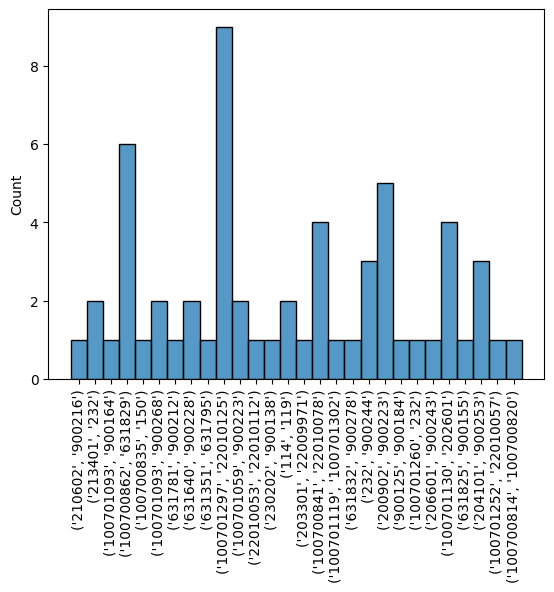

In [17]:
g = sns.histplot(vis_data)
plt.xticks(rotation=90);